In [1]:
import re
import time
from tqdm import tqdm

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import plotly.graph_objects as go
from   plotly.subplots import make_subplots

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Из всех столбцов данных для позитивных и негативных высказываний в одной из социальных сетей выделим только текст, несущий эмоциональную окраску, и добавим столбец с нулями - для негативных высказываний и единицами - для позитивных.


In [3]:
positive = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/positive.csv',
                       sep = ';',
                       header= None
                      )

In [4]:
negative = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/negative.csv',
                       sep = ';',
                       header= None
                      )

In [5]:
positive_text = pd.DataFrame(positive.iloc[:, 3])
negative_text = pd.DataFrame(negative.iloc[:, 3])
positive_text['label'] = [1] * positive_text.shape[0]
negative_text['label'] = [0] * negative_text.shape[0]

Объеденим полученные данные в один датасет.

In [6]:
labeled_tweets = pd.concat([positive_text, negative_text])
labeled_tweets.index = range(labeled_tweets.shape[0])
labeled_tweets.columns = ['text', 'label']
labeled_tweets

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1
...,...,...
226829,Но не каждый хочет что то исправлять:( http://...,0
226830,скучаю так :-( только @taaannyaaa вправляет мо...,0
226831,"Вот и в школу, в говно это идти уже надо(",0
226832,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0


## Очистка размеченного датасета *Им. начальника подотдела очистки тов. Шарикова П. П.*

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# Оставим в тексте только кириллические символы
def clear_text(text):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return " ".join(clear_text.split())


# напишем функцию удаляющую стоп-слова
def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

In [9]:
# загрузим список стоп-слов
stopwords = set(nltk_stopwords.words('russian'))
np.array(stopwords)

array({'нибудь', 'этой', 'же', 'был', 'них', 'они', 'но', 'ним', 'чтобы', 'ли', 'ж', 'мой', 'всегда', 'ей', 'будет', 'во', 'потому', 'тут', 'была', 'нее', 'нет', 'к', 'меня', 'да', 'конечно', 'у', 'сейчас', 'при', 'с', 'более', 'ведь', 'чуть', 'между', 'так', 'хоть', 'куда', 'даже', 'чтоб', 'из', 'никогда', 'свою', 'тоже', 'лучше', 'чем', 'какой', 'разве', 'один', 'вот', 'мы', 'него', 'этот', 'про', 'под', 'еще', 'со', 'мне', 'от', 'и', 'впрочем', 'раз', 'тогда', 'какая', 'не', 'до', 'всю', 'ее', 'можно', 'уже', 'быть', 'вас', 'эту', 'что', 'когда', 'уж', 'об', 'о', 'после', 'перед', 'ней', 'только', 'им', 'ты', 'ну', 'три', 'совсем', 'если', 'их', 'этого', 'она', 'потом', 'без', 'ни', 'почти', 'чего', 'наконец', 'тем', 'на', 'нас', 'всех', 'он', 'то', 'в', 'ему', 'или', 'этом', 'за', 'моя', 'бы', 'как', 'может', 'над', 'я', 'себе', 'сам', 'такой', 'по', 'вдруг', 'здесь', 'зачем', 'его', 'иногда', 'были', 'эти', 'два', 'ничего', 'для', 'где', 'там', 'надо', 'того', 'все', 'много', 'чер

In [11]:
# Протестируем работу функции очистки текста для случайной строки
text = labeled_tweets['text'][np.random.randint(labeled_tweets.shape[0])]
print(text)
print('=======================================')
print(clean_stop_words((clear_text(text)), stopwords))

@MrsRourke_s_tit @Dane_Rider @igeshka @dyu_bryun не хочу тебя разочаровывать, Кариш, но он такой. он может :)
хочу разочаровывать кариш


## *Пока всё работало быстро. Посмотрим, что будет тут.*

Очищаем весь датасет от стопслов

In [12]:
%%time
labeled_tweets['text_clear'] = labeled_tweets['text']\
                              .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

CPU times: user 2.79 s, sys: 38 ms, total: 2.83 s
Wall time: 2.83 s


In [13]:
labeled_tweets = labeled_tweets[['text_clear', 'label']]
labeled_tweets

,text_clear,label
0,школота поверь самое общество профилирующий пр...,1
1,таки немного похож мальчик равно,1
2,идиотка испугалась,1
3,углу сидит погибает голода ещё порции взяли хо...,1
4,значит страшилка блин посмотрев части создастс...,1
...,...,...
226829,каждый хочет исправлять,0
226830,скучаю вправляет мозги равно скучаю,0
226831,школу говно это идти,0
226832,тауриэль грусти обнял,0


## Лемматизация текстов

In [14]:
def lemmatize(df : (pd.Series, pd.DataFrame),
              text_column : (None, str),
              n_samples : int,
              break_str = 'br',
             ) -> pd.Series:
  result = []
  m = Mystem()
 # изменения в прогресс-баре успокаивает пользователя
 # он видит нe только что процесс идёт, но и как быстро
  for i in tqdm(range((df.shape[0] // n_samples) + 1)) :
    start = i * n_samples
    stop = start + n_samples
    sample = break_str.join(df[text_column][start : stop].values)
    lemmas = m.lemmatize(sample)
    lemm_sample = ''.join(lemmas).split(break_str)
    result += lemm_sample
  return pd.Series(result, index = df.index)

In [15]:
labeled_tweets['lemm_text_clear'] = lemmatize(
    df = labeled_tweets,
    text_column = 'text_clear',
    n_samples = 1000,
    break_str = 'br',
    )

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
100%|██████████| 227/227 [01:20<00:00,  2.82it/s]


In [16]:
labeled_tweets

,text_clear,label,lemm_text_clear
0,школота поверь самое общество профилирующий пр...,1,школоть поверять самый общество профилировать ...
1,таки немного похож мальчик равно,1,таки немного похожий мальчик равно
2,идиотка испугалась,1,идиотка испугалась
3,углу сидит погибает голода ещё порции взяли хо...,1,углу сидеть погибать голод еще порция взять хо...
4,значит страшилка блин посмотрев части создастс...,1,значит страшилка блин посмотреть часть создава...
...,...,...,...
226829,каждый хочет исправлять,0,каждый хотеть исправлять
226830,скучаю вправляет мозги равно скучаю,0,скучаю вправлять мозги равный скучаю
226831,школу говно это идти,0,школу гавно это идти
226832,тауриэль грусти обнял,0,тауриэль грусть обнял


In [17]:
train, test = train_test_split(
  											labeled_tweets,
                        test_size = 0.2,
  											stratify = labeled_tweets['label'],
                        random_state = 2048,
                       )

In [18]:
train

,text_clear,label,lemm_text_clear
175929,шайсэ скольки скольки,0,шайсэ сколька скольки
43349,придумал выражение доброго времени суток велик...,1,придумал выражение добрый время сутки великий ...
47927,говорят уткин болельщикам локомотива посрался ...,1,говорят уткин болельщик локомотив посраться ра...
24466,люби никого будешь нравиться всем посылай чёрт...,1,люби никто быть нравиться все посылать черт ве...
1753,блейн сэм,1,блейн сэм
...,...,...,...
173990,остров погибших кораблей серия фильмы анимация...,0,остров погибший корабль серия фильм анимация с...
87603,ленин любимый франциск,1,ленин любимый франциск
56177,такое ощущение дал глаза переворачивает внутри...,1,такое ощущение давать глаз перевертывать внутр...
64485,поддерживаю клевоклевоклево нужно фильмов глян...,1,поддерживаю клевоклевоклевый нужно фильм гляну...


In [19]:
# Сравним распределение целевого признака
for sample in [train, test]:
    print(sample[sample['label'] == 1].shape[0] / sample.shape[0])

0.506587974673081
0.506579672449137


In [20]:
count_idf_positive = TfidfVectorizer(ngram_range = (1,1))
count_idf_negative = TfidfVectorizer(ngram_range = (1,1))

tf_idf_positive = count_idf_positive.fit_transform(train.query('label == 1')['lemm_text_clear'])
tf_idf_negative = count_idf_negative.fit_transform(train.query('label == 0')['lemm_text_clear'])

In [21]:
# Сохраним списки Idf для каждого класса
positive_importance = pd.DataFrame(
    {'word' : count_idf_positive.get_feature_names_out(),
     'idf' : count_idf_positive.idf_
    }).sort_values(by = 'idf', ascending = False)

negative_importance = pd.DataFrame(
    {'word' : count_idf_negative.get_feature_names_out(),
     'idf' : count_idf_negative.idf_
    }).sort_values(by = 'idf', ascending = False)

In [22]:
positive_importance

,word,idf
81292,ёёёёёёёёёёёёёёёёёёёёёлки,11.735636
34367,миланка,11.735636
63065,слили,11.735636
34370,миланчик,11.735636
34371,миланья,11.735636
...,...,...
64976,спасибо,4.470556
55597,просто,4.414116
61429,сегодня,4.258031
15331,день,4.218930


In [23]:
negative_importance

,word,idf
22218,кашлю,11.709282
28976,мимимиться,11.709282
28978,мимимишный,11.709282
28979,мимический,11.709282
28980,мимишество,11.709282
...,...,...
38361,очень,4.386442
52376,сегодня,4.265619
64961,хотеть,4.220429
12789,день,4.170255


In [24]:
positive_importance.query('word not in @negative_importance.word and idf < 11.0')

,word,idf
70322,трёх,10.819345
38975,ненадобностью,10.819345
42141,одпузг,10.819345
5245,близится,10.819345
60486,саму,10.819345
...,...,...
16134,диске,9.209907
28732,котята,9.170686
49708,поздравляем,9.096578
76768,царевич,7.765344


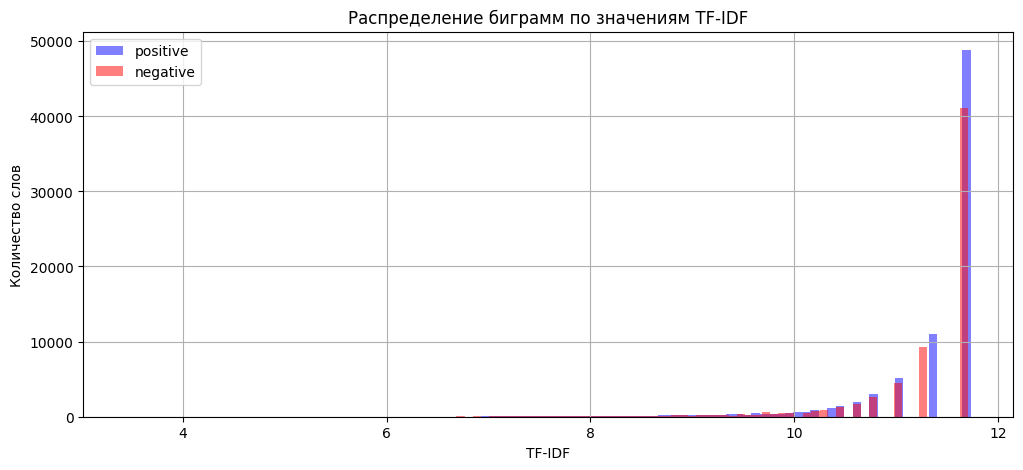

In [25]:
fig = plt.figure(figsize = (12,5))
positive_importance.idf.hist(bins = 100,
                             label = 'positive',
                             alpha = 0.5,
                             color = 'b',
                            )
negative_importance.idf.hist(bins = 100,
                             label = 'negative',
                             alpha = 0.5,
                             color = 'r',
                            )
plt.title('Распределение биграмм по значениям TF-IDF')
plt.xlabel('TF-IDF')
plt.ylabel('Количество слов')
plt.legend()
plt.show()

## *Построим модели для исходного текста и лемменизированного.*

## *Сначала для просто очищенного текста*

In [26]:
# Получим векторные представления текстов
count_idf_1 = TfidfVectorizer(ngram_range=(1,1))

In [27]:
tf_idf_base_1 = count_idf_1.fit(labeled_tweets['text_clear'])
tf_idf_train_base_1 = count_idf_1.transform(train['text_clear'])
tf_idf_test_base_1 = count_idf_1.transform(test['text_clear'])
#t = count_idf_1.transform(['прощайте скалистые горы'])

In [29]:
display(tf_idf_train_base_1.shape)
display(tf_idf_test_base_1.shape)

(181467, 170344)

(45367, 170344)

In [30]:
model_lr_base_1 = LogisticRegression(solver = 'lbfgs',
                                    random_state = 2024,
                                    max_iter= 10000,
                                    n_jobs= -1)

In [31]:
model_lr_base_1.fit(tf_idf_train_base_1, train['label'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=2024)

In [32]:
predict_lr_base_proba = model_lr_base_1.predict_proba(tf_idf_test_base_1)

In [33]:
predict_lr_base_proba

array([[0.80808016, 0.19191984],
       [0.43311658, 0.56688342],
       [0.84744992, 0.15255008],
       ...,
       [0.6354644 , 0.3645356 ],
       [0.66094642, 0.33905358],
       [0.50542421, 0.49457579]])

## *Теперь для лемматизированного*


In [59]:
# Получим векторное представление лемматизированного текста
tf_idf_test_lemm = count_idf_1.transform(test['lemm_text_clear'])
tf_idf_train_lemm = count_idf_1.transform(train['lemm_text_clear'])

display(tf_idf_test_lemm.shape)

(45367, 170344)

In [60]:
model_lr_lemm = LogisticRegression(solver = 'lbfgs',
                                    random_state = 2024,
                                    max_iter= 10000,
                                    n_jobs= -1)

In [61]:
model_lr_lemm.fit(tf_idf_train_lemm, train['label'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=2024)

In [62]:
predict_lr_lemm_proba = model_lr_lemm.predict_proba(tf_idf_test_lemm)

Две модели построены, можно сравнивать.

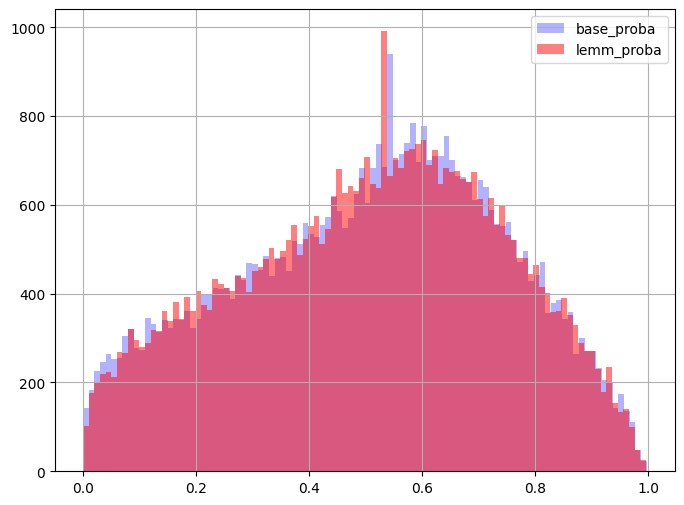

In [63]:
fif = plt.figure(figsize = (8, 6))

pd.Series(predict_lr_base_proba[:, 1])\
                .hist(bins = 100,
                      alpha = 0.3,
                      color = 'b',
                      label = 'base_proba'
                     )



pd.Series(predict_lr_lemm_proba[:, 1])\
                .hist(bins = 100,
                      alpha = 0.5,
                      color = 'r',
                      label = 'lemm_proba'
                     )
plt.legend()
plt.show()

In [64]:
# Выведем матрицы ошибок
confusion_matrix(test['label'],
                 (predict_lr_base_proba[:, 1] > 0.5).astype('float'),
                 normalize='true',
                )

array([[0.69032834, 0.30967166],
       [0.22548081, 0.77451919]])

In [65]:
# Выведем матрицы ошибок
confusion_matrix(test['label'],
                 (predict_lr_lemm_proba[:, 1] > 0.5).astype('float'),
                 normalize='true',
                )

array([[0.68188519, 0.31811481],
       [0.24667131, 0.75332869]])

## *Немного визуализации*

In [66]:
# Получим веса признаков, то есть множители
# подобранные логистической регрессией
# для каждого компонента вектора tf-idf

weights = pd.DataFrame({'words': count_idf_1.get_feature_names_out(),
                        'weights': model_lr_base_1.coef_.flatten()})
weights_min = weights.sort_values(by= 'weights')
weights_max = weights.sort_values(by= 'weights', ascending = False)

In [67]:
weights_min = weights_min[10:110]
weights_min['weights'] = weights_min['weights'] * -1
weights_max = weights_max[10:110]
weights_max

<ipython-input-67-181c13dd0630>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weights_min['weights'] = weights_min['weights'] * -1


,words,weights
5540,ахахаха,3.470013
137002,спасибо,3.412967
92324,отличного,3.376228
152729,ура,3.354616
119350,рад,3.235457
...,...,...
92323,отлично,2.042173
102883,поднимает,2.040380
30378,дата,2.039048
39424,желаю,2.021037


In [68]:
wordcloud_positive = WordCloud(background_color="white",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None,
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_max.values))

wordcloud_negative = WordCloud(background_color="black",
                               colormap = 'Reds',
                               max_words=200,
                               mask=None,
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_min.values))

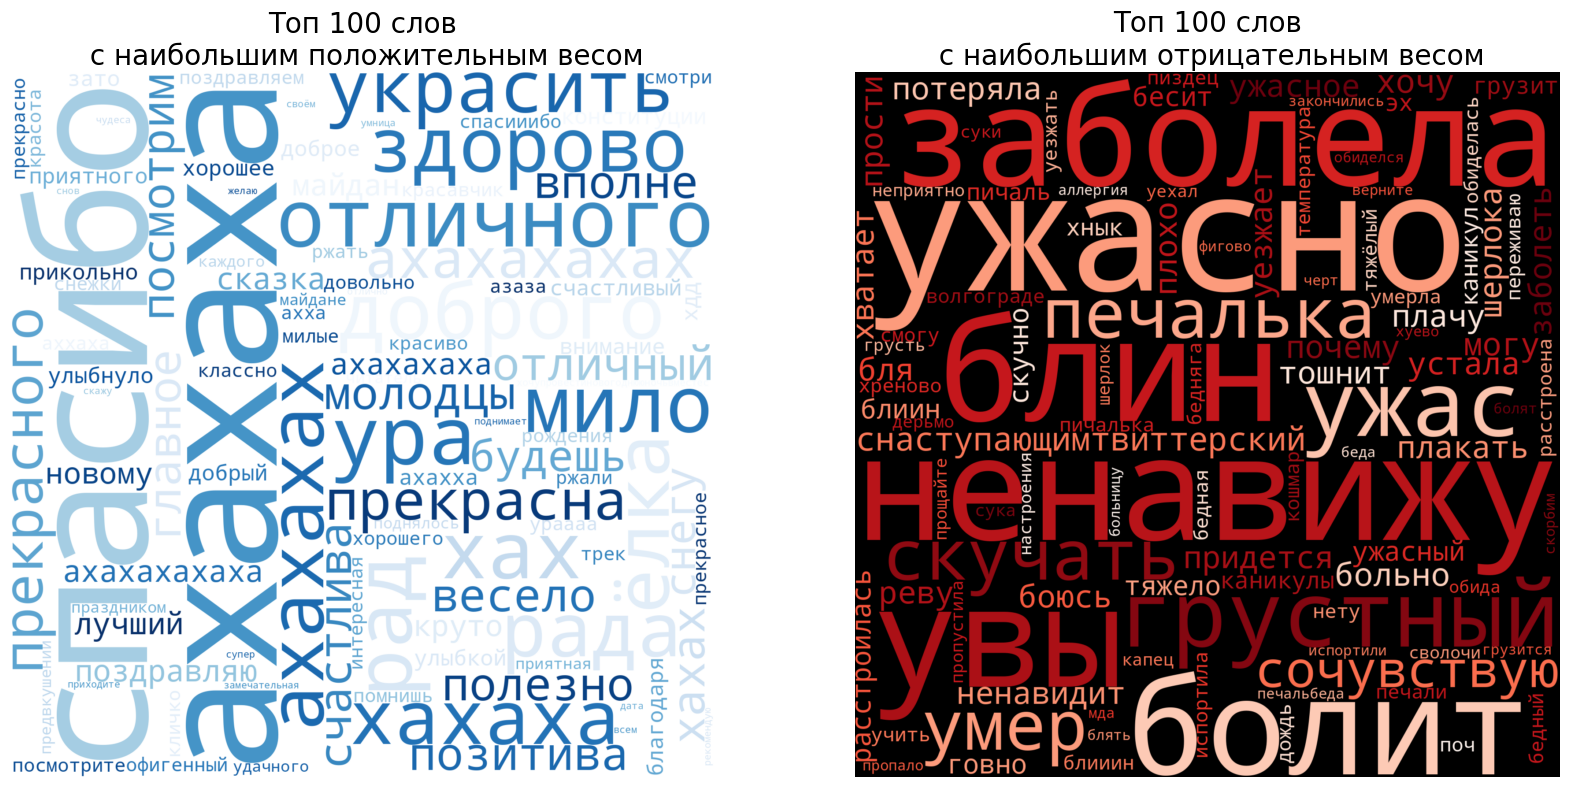

In [69]:
# Выведем картинки сгенерированные вордклаудом
fig, ax = plt.subplots(1, 2, figsize = (20, 12))


ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].imshow(wordcloud_negative, interpolation='bilinear')

ax[0].set_title('Топ ' +\
                str(weights_max.shape[0]) +\
                ' слов\n с наибольшим положительным весом',
               fontsize = 20
               )
ax[1].set_title('Топ ' +\
                str(weights_min.shape[0]) +\
                ' слов\n с наибольшим отрицательным весом',
               fontsize = 20
               )

ax[0].axis("off")
ax[1].axis("off")

plt.show()

## *Проверим работу оценки эмоциональной окраски текста на примере афоризмов Козьмы пруткова.*

Понятно, что с учетом натренированости модели на высказываниях из Т* результат будет интересным.

In [52]:
#считаем текстовые данные
k_p = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/k_p_1.csv',
                       sep = ';',
                       header= None
                      ).add_prefix("text")

In [53]:
k_p

,text0
0,Добродетель служит сама себе наградой; человек...
1,Вред или польза действия обусловливается совок...
2,"Не будь цветов, все ходили бы в одноцветных од..."
3,Ветер есть дыхание природы.
4,На беспристрастном безмене истории кисть Рафаэ...
...,...
154,Не шути с женщинами: эти шутки глупы и неприли...
155,"Чрезмерный богач, не помогающий бедным, подобе..."
156,Магнит показывает на север и на юг; от человек...
157,На чужие ноги лосины не натягивай.


In [54]:
k_p_c = k_p['text0'].apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

In [ ]:
k_p.insert(loc = 1, column='text_clear', value = k_p_c)


In [57]:
k_p['lemm_text_clear'] = lemmatize(
    df = k_p,
    text_column = 'text_clear',
    n_samples = 1000,
    break_str = 'br',
    )

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


In [58]:
k_p

,text0,text_clear,lemm_text_clear
0,Добродетель служит сама себе наградой; человек...,добродетель служит сама наградой человек прево...,добродетель служить сам награда человек превос...
1,Вред или польза действия обусловливается совок...,вред польза действия обусловливается совокупно...,вред польза действие обусловливаться совокупно...
2,"Не будь цветов, все ходили бы в одноцветных од...",будь цветов ходили одноцветных одеяниях,будь цветок ходить одноцветный одеяниях
3,Ветер есть дыхание природы.,ветер дыхание природы,ветер дыхание природы
4,На беспристрастном безмене истории кисть Рафаэ...,беспристрастном безмене истории кисть рафаэля ...,беспристрастном безмен история кисть рафаэль и...
...,...,...,...
154,Не шути с женщинами: эти шутки глупы и неприли...,шути женщинами шутки глупы неприличны,шути женщина шутка глупый неприличны
155,"Чрезмерный богач, не помогающий бедным, подобе...",чрезмерный богач помогающий бедным подобен здо...,чрезмерный богач помогать бедный подобный здор...
156,Магнит показывает на север и на юг; от человек...,магнит показывает север юг человека зависит из...,магнит показывать север юг человек зависеть из...
157,На чужие ноги лосины не натягивай.,чужие ноги лосины натягивай,чужие нога лосина натягивай


## *Проверим насколько Козьма Прутков позитивен!*

In [108]:
for _ in range(5):

    source = k_p.sample(n=1)
    text_clear = source['text_clear'].values[0]
    text = source['text0'].values[0]

    print(text)
    t = count_idf_1.transform([text_clear])

    t_p = model_lr_base_1.predict_proba(t)
    t_p_l       = model_lr_lemm.predict_proba(t)

    print('Очищенный.         Вероятность негатива: ', t_p[:, 0] , ' вероятность позитива:  ', t_p[:, 1])
    print('Лемменизированный. Вероятность негатива: ', t_p_l[:, 0] , ' вероятность позитива:  ', t_p_l[:, 1], '\n')


И египтяне были в свое время справедливы и человеколюбивы!
Очищенный.         Вероятность негатива:  [0.45614259]  вероятность позитива:   [0.54385741]
Лемменизированный. Вероятность негатива:  [0.47479955]  вероятность позитива:   [0.52520045] 

Детям, у коих прорезываются зубы, смело присоветую фиалковый корень!
Очищенный.         Вероятность негатива:  [0.42180719]  вероятность позитива:   [0.57819281]
Лемменизированный. Вероятность негатива:  [0.29893672]  вероятность позитива:   [0.70106328] 

Продолжать смеяться легче, чем окончить смех!
Очищенный.         Вероятность негатива:  [0.06964388]  вероятность позитива:   [0.93035612]
Лемменизированный. Вероятность негатива:  [0.06775985]  вероятность позитива:   [0.93224015] 

Память человека есть лист белой  бумаги:  иногда  напишется  хорошо,  а иногда дурно.
Очищенный.         Вероятность негатива:  [0.4818633]  вероятность позитива:   [0.5181367]
Лемменизированный. Вероятность негатива:  [0.55363898]  вероятность позитива:   [0.44